# import modules

In [1]:
import sys

sys.path.insert(0, "../")

from modules.Classes_ver1 import *
from modules.default_params_ver1 import *
from modules.functions_ver1 import *

# # after making changes to scripts, reload them
# import importlib

# import scripts.Classes_ver1
# importlib.reload(scripts.Classes_ver1)
# from scripts.Classes_ver1 import *

# import scripts.default_params_ver1
# importlib.reload(scripts.default_params_ver1)
# from scripts.default_params_ver1 import *

# import scripts.functions_ver1
# importlib.reload(scripts.functions_ver1)
# from scripts.functions_ver1 import *

# define PrecessingTaman

In [3]:
class PrecessingTaman(Precessing):
    def __init__(self, params):
        super().__init__(params)

    ### get the delta phi_P
    def integrand_delta_phi(self, y, f):
        """integrand for delta phi p (equations in Apostolatos 1994, and appendix of Evangelos in prep)"""
        LdotN = self.LdotN(f)
        cos_i_JN, sin_i_JN, cos_o_XH, sin_o_XH = self.precession_angles()
        f_dot = self.f_dot(f)

        Omega_LJ = (
            1000
            * self.omega_tilde
            * (f / self.f_cut()) ** (5 / 3)
            / (self.total_mass() / self.SOLMASS2SEC)
        )

        integrand_delta_phi = (
            (LdotN / (1 - LdotN**2))
            * Omega_LJ
            * np.sin(self.theta_LJ(f))
            * (
                np.cos(self.theta_LJ(f)) * sin_i_JN * np.sin(self.phi_LJ(f))
                - np.sin(self.theta_LJ(f)) * cos_i_JN
            )
            / f_dot
        )

        # if self.theta_tilde == 0:
        # integrand_delta_phi = - Omega_LJ

        if cos_i_JN == 1:
            integrand_delta_phi = -Omega_LJ * np.cos(self.theta_LJ(f)) / f_dot

        # if LdotN == 1:
        # integrand_delta_phi = 0

        return integrand_delta_phi

# define mismatch slice functions

In [10]:
lens_params, RP_params, NP_params = set_to_params(
    lens_params_0, RP_params_0, NP_params_0
)

# using Saif's choice of sky locations
sky_locs_J, sky_locs_S = set_to_params(sky_locs_J_S, sky_locs_S_S)


def mismatch_plot_panel(
    param_name, param_unit, param_array, xlabel, title, lens_Class, prec_Class
):
    # plot mismatch as a function of param_name
    global lens_params, RP_params, NP_params, sky_locs_J, sky_locs_S

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 12))
    fig.subplots_adjust(hspace=0.5)
    fig.subplots_adjust(wspace=0.5)

    for r, ((theta_J, phi_J), (theta_S, phi_S)) in enumerate(
        zip(sky_locs_J, sky_locs_S)
    ):
        # set lensed, RP, NP to same location
        lens_params["theta_L"] = RP_params["theta_J"] = NP_params["theta_J"] = theta_J
        lens_params["phi_L"] = RP_params["phi_J"] = NP_params["phi_J"] = phi_J
        lens_params["theta_S"] = RP_params["theta_S"] = NP_params["theta_S"] = theta_S
        lens_params["phi_S"] = RP_params["phi_S"] = NP_params["phi_S"] = phi_S

        I_array = np.empty(0)
        Delta_td_array = np.empty(0)

        for cmd in ["L & RP", "L & NP", "RP & NP"]:
            ep_array = []

            for param in param_array:
                if param_name in lens_params.keys():
                    lens_params[param_name] = param * param_unit
                if param_name in RP_params.keys():
                    RP_params[param_name] = param * param_unit
                if (param_name in NP_params.keys()) and (
                    param_name not in ["theta_tilde", "omega_tilde", "gamma_P"]
                ):
                    NP_params[param_name] = param * param_unit

                if (cmd == "L & NP") and (xlabel == r"$I$"):
                    lensing_inst = LensingGeo(lens_params)
                    I_array = np.append(I_array, lensing_inst.I())

                if (cmd == "L & RP") and (xlabel == r"$\Delta t_d$"):
                    lensing_inst = LensingGeo(lens_params)
                    Delta_td_array = np.append(Delta_td_array, lensing_inst.Delta_td())

                ep_min, g_min, ep_max, g_max, ep_0 = optimize_mismatch_gammaP(
                    cmd, lens_params, RP_params, NP_params, lens_Class, prec_Class
                )

                ep_array.append(ep_min)

            ls = {"L & RP": "-", "L & NP": "--", "RP & NP": ":"}
            color = plt.rcParams["axes.prop_cycle"].by_key()["color"][r]

            if xlabel == r"$I$":
                axes[r].plot(I_array, ep_array, ls=ls[cmd], color=color, label=cmd)
            elif xlabel == r"$\Delta t_d$":
                axes[r].plot(
                    Delta_td_array, ep_array, ls=ls[cmd], color=color, label=cmd
                )
            else:
                axes[r].plot(param_array, ep_array, ls=ls[cmd], color=color, label=cmd)

            axes[r].legend()
            axes[r].set_xlabel(xlabel)
            axes[r].set_ylabel(r"$\epsilon$")
            axes[r].set_title(
                r"$\theta_J$ = {:.3g}, $\phi_J$ = {:.3g}, $\theta_S$ = {:.3g}, $\phi_S$ = {:.3g}".format(
                    theta_J, phi_J, theta_S, phi_S
                )
            )

    fig.suptitle(title, fontsize=16)

In [11]:
def mismatch_slice_P_Omega(l_params, rp_params, np_params, cmd, lens_Class, prec_Class):
    ep_array = []
    omega_tilde_array = np.linspace(0, 3, 100)

    for omega_tilde in omega_tilde_array:
        rp_params["omega_tilde"] = omega_tilde
        ep_min, g_min, ep_max, g_max, ep_0 = optimize_mismatch_gammaP(
            cmd, l_params, rp_params, np_params, lens_Class, prec_Class
        )
        ep_array.append(ep_min)

    plt.plot(omega_tilde_array, ep_array)
    plt.grid()
    plt.xlabel(r"$\tilde{\Omega}$")
    plt.ylabel(r"$\epsilon(\~h_{\rm RP}, \~h_{\rm L})$")
    plt.title(
        r"$\theta_L$ = {:.3g}, $\phi_L$ = {:.3g}, $\theta_S$ = {:.3g}, $\phi_S$ = {:.3g}, {} = {:.3g}, {} = {:.3g}".format(
            l_params["theta_L"],
            l_params["phi_L"],
            l_params["theta_S"],
            l_params["phi_S"],
            r"$y$",
            l_params["y"],
            r"$M_{Lz}$",
            l_params["MLz"] / solar_mass,
        )
    )


def mismatch_slice_P_theta(l_params, rp_params, np_params, cmd, lens_Class, prec_Class):
    ep_array = []
    theta_tilde_array = np.linspace(0, 8, 100)

    for theta_tilde in theta_tilde_array:
        rp_params["theta_tilde"] = theta_tilde
        ep_min, g_min, ep_max, g_max, ep_0 = optimize_mismatch_gammaP(
            cmd, l_params, rp_params, np_params, lens_Class, prec_Class
        )
        ep_array.append(ep_min)

    plt.plot(theta_tilde_array, ep_array)
    plt.grid()
    plt.xlabel(r"$\tilde{\theta}$")
    plt.ylabel(r"$\epsilon(\~h_{\rm RP}, \~h_{\rm L})$")
    plt.title(
        r"$\theta_L$ = {:.3g}, $\phi_L$ = {:.3g}, $\theta_S$ = {:.3g}, $\phi_S$ = {:.3g}, {} = {:.3g}, {} = {:.3g}".format(
            l_params["theta_L"],
            l_params["phi_L"],
            l_params["theta_S"],
            l_params["phi_S"],
            r"$y$",
            l_params["y"],
            r"$M_{Lz}$",
            l_params["MLz"] / solar_mass,
        )
    )

## mismatch slices using LensingGeo & Precessing

/var/folders/y_/v4l1jv1j5b55928djlvnhnm40000gp/T/ipykernel_44695/294510818.py:137: RuntimeWarning: divide by zero encountered in divide
  tan_psi = num_psi / den_psi


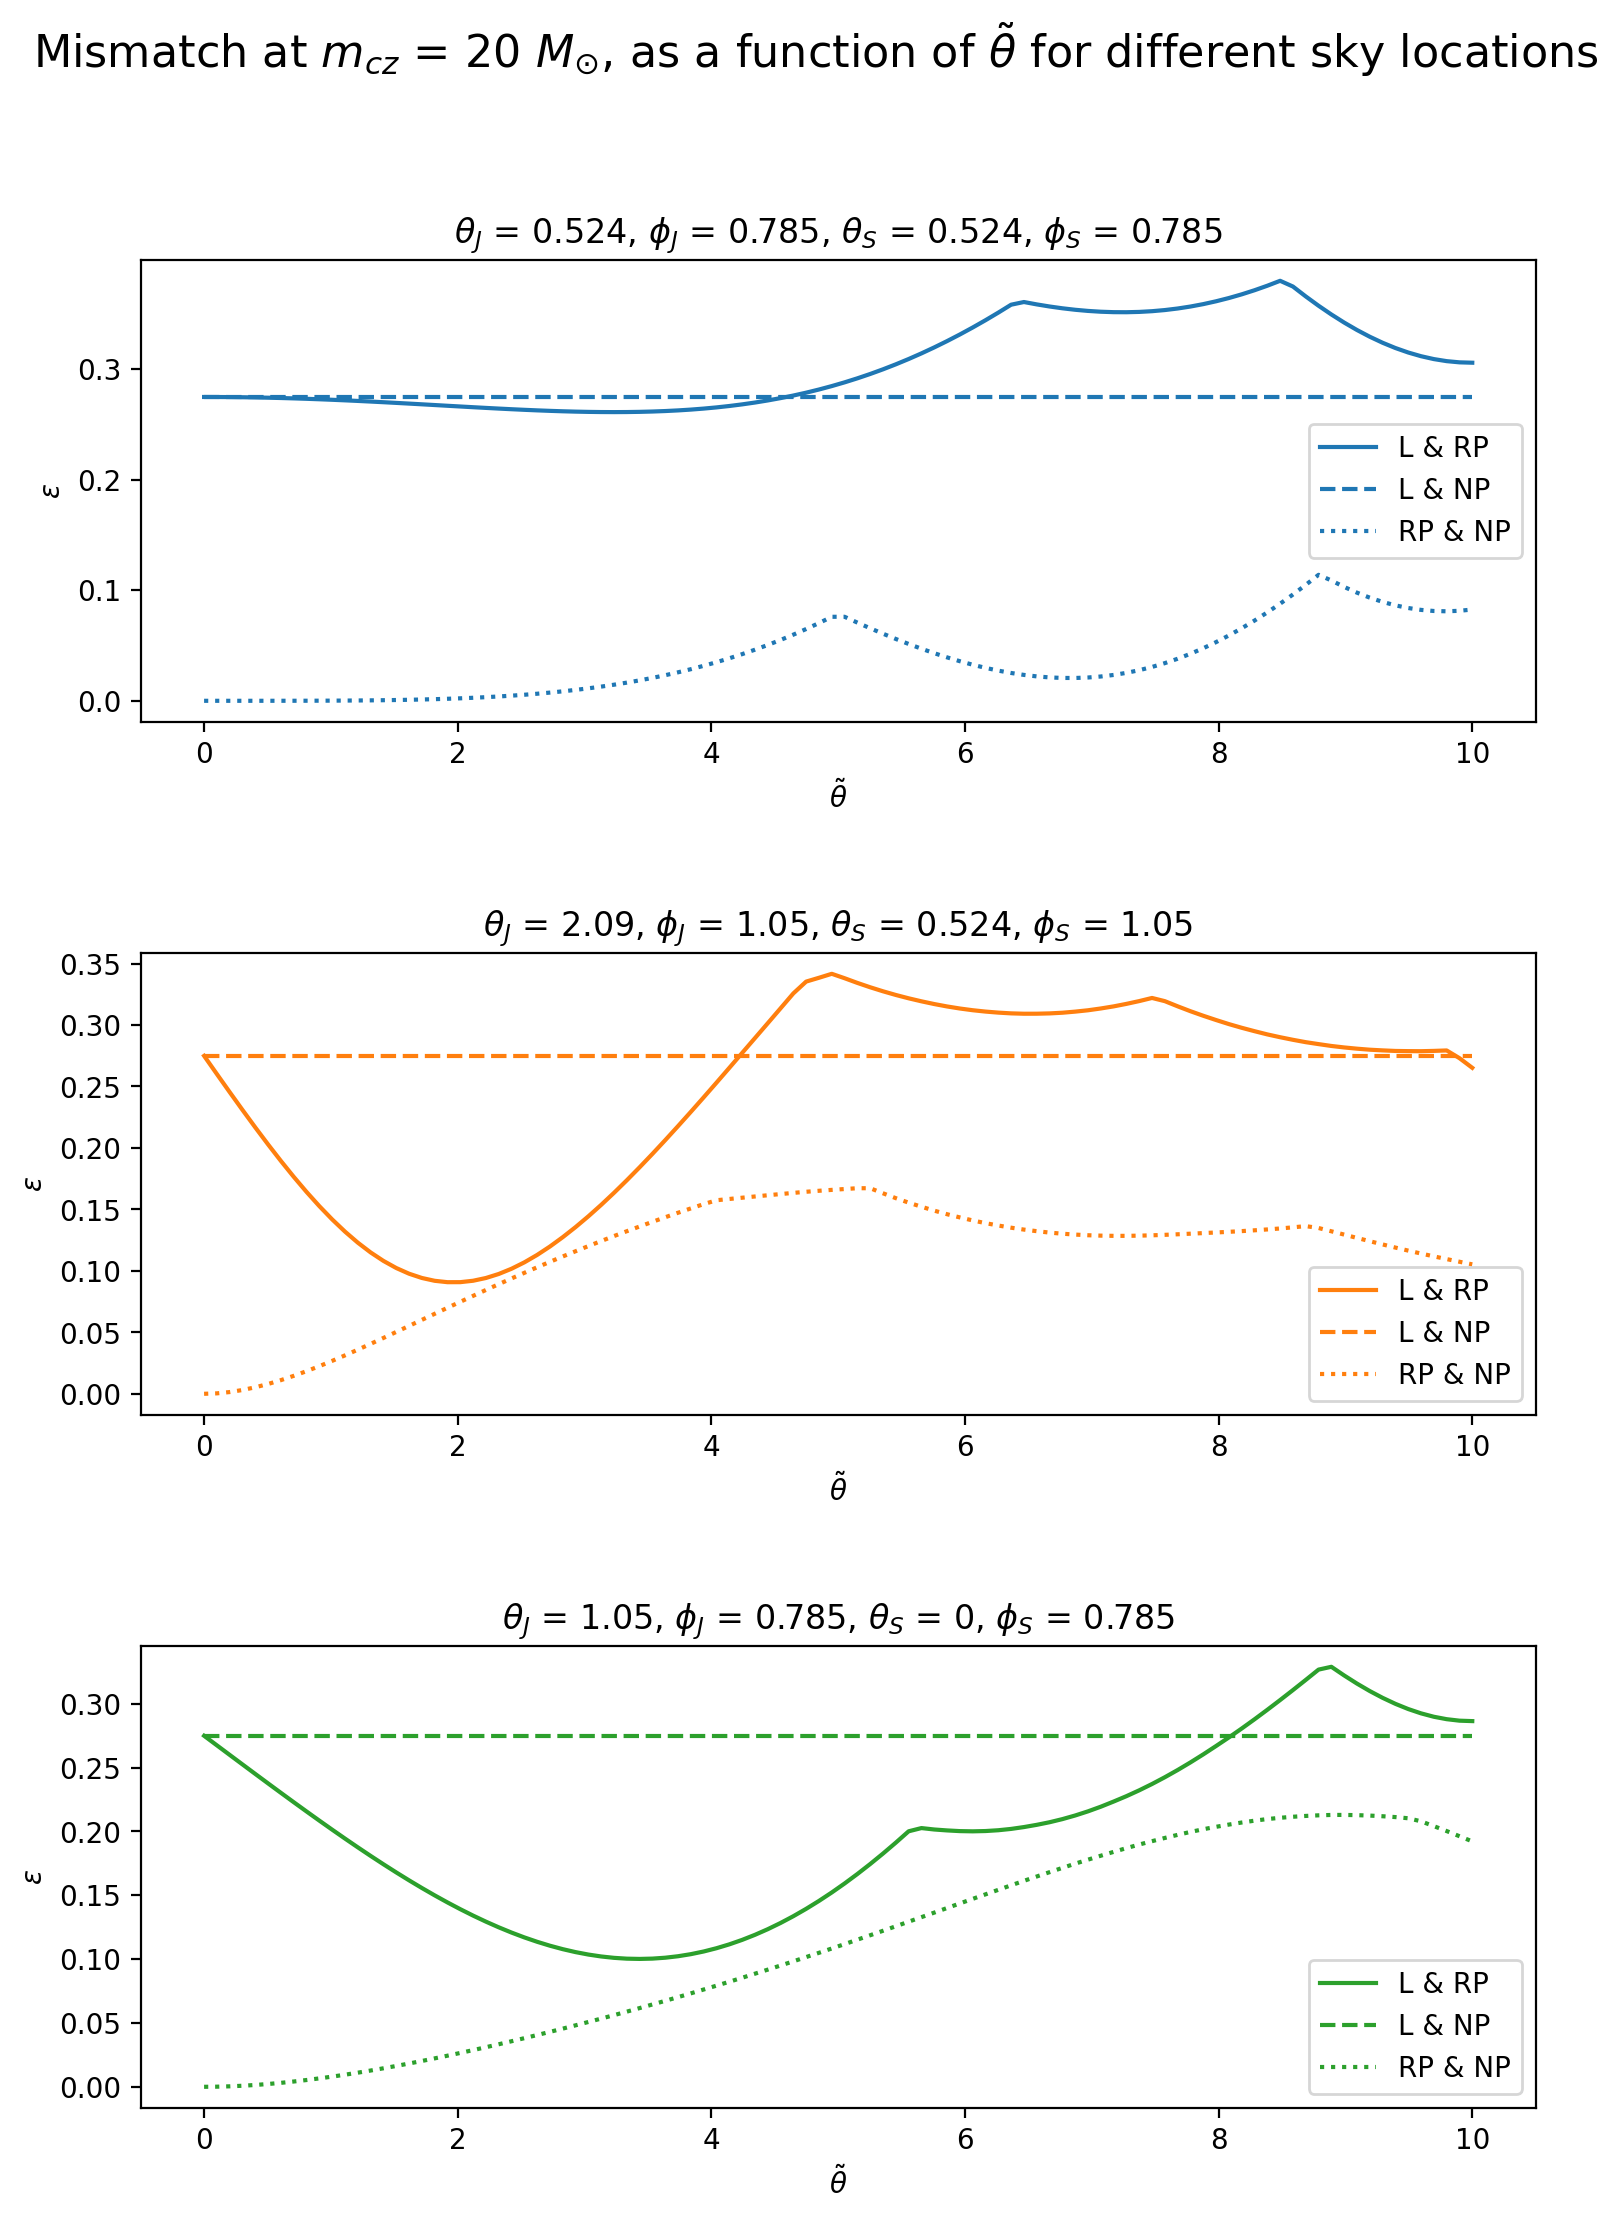

In [40]:
lens_params, RP_params, NP_params = set_to_params(
    lens_params_0, RP_params_0, NP_params_0
)

# using Saif's choice of sky locations
sky_locs_J, sky_locs_S = set_to_params(sky_locs_J_S, sky_locs_S_S)

# assign mcz to 20
mcz = 20
lens_params["mcz"] = RP_params["mcz"] = NP_params["mcz"] = mcz * solar_mass

# assign omega_tilde to 5
omega_tilde = 3
RP_params["omega_tilde"] = omega_tilde

# plot mismatch panel as a function of theta_tilde
theta_tilde_array = np.linspace(0, 10, 100)

mismatch_plot_panel(
    "theta_tilde",
    1,
    theta_tilde_array,
    r"$\tilde{\theta}$",
    r"Mismatch at $m_{cz}$ = 20 $M_{\odot}$, as a function of $\tilde{\theta}$ for different sky locations",
    LensingGeo,
    Precessing,
)

/var/folders/y_/v4l1jv1j5b55928djlvnhnm40000gp/T/ipykernel_44695/294510818.py:137: RuntimeWarning: divide by zero encountered in divide
  tan_psi = num_psi / den_psi


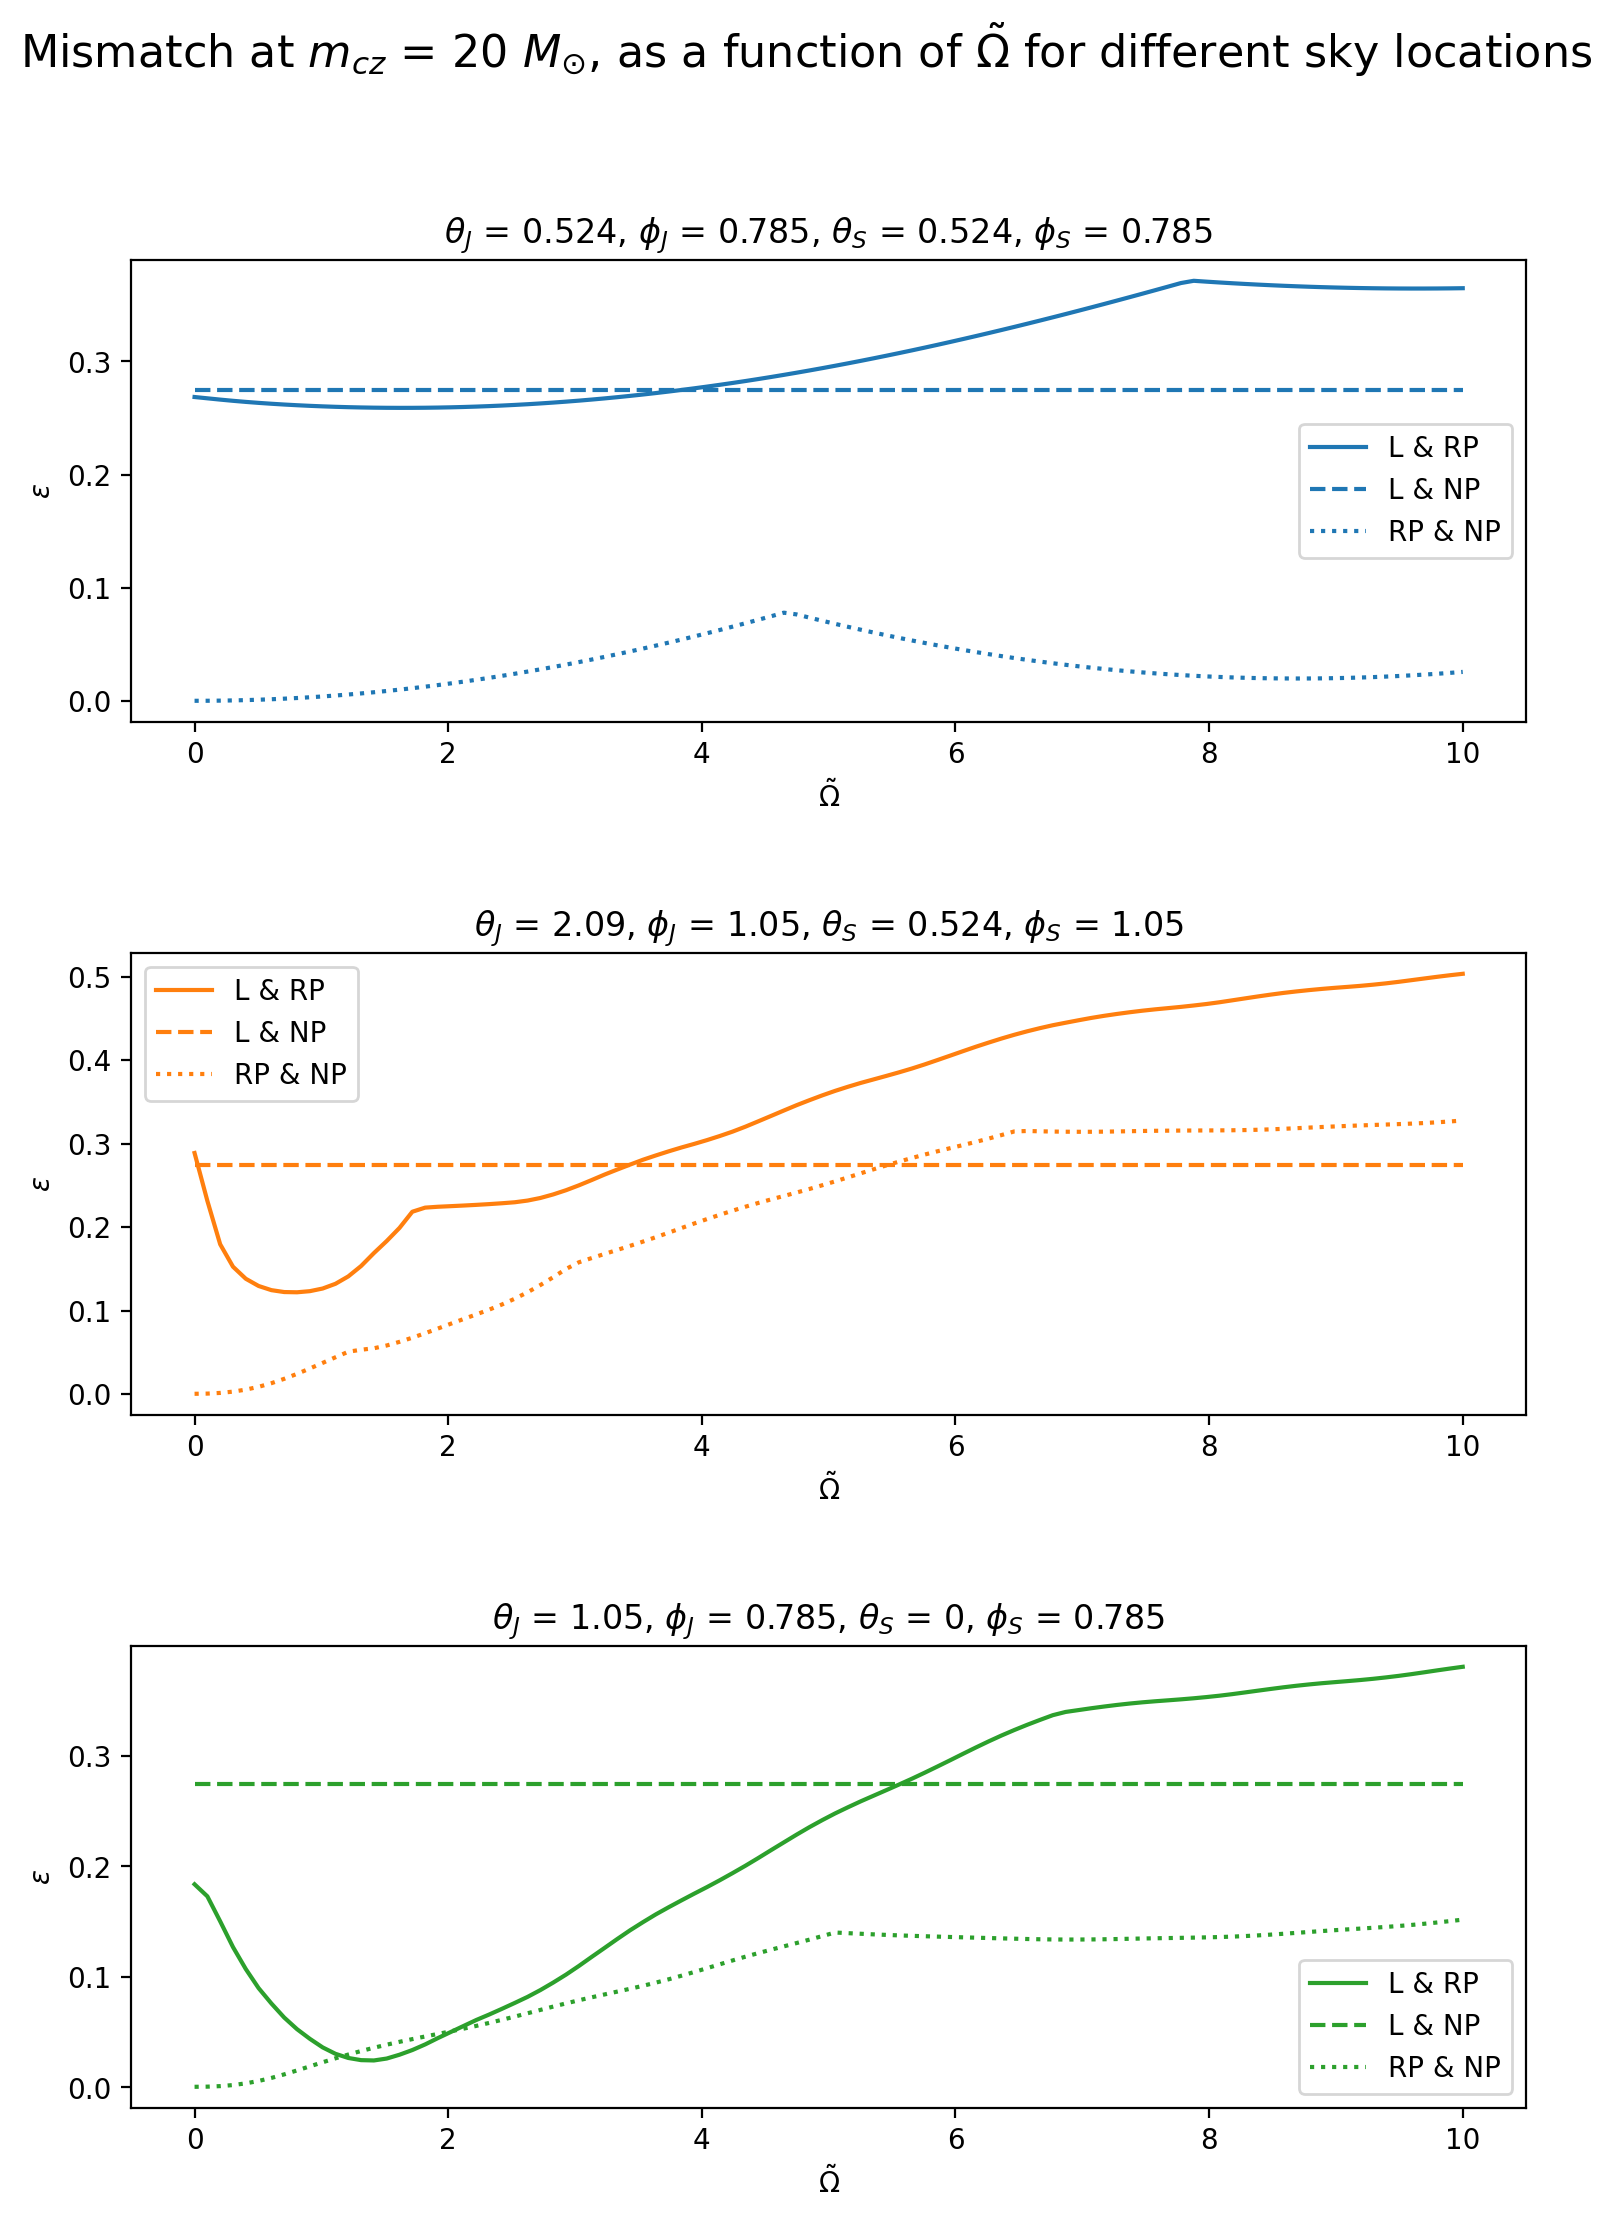

In [41]:
lens_params, RP_params, NP_params = set_to_params(
    lens_params_0, RP_params_0, NP_params_0
)

# using Saif's choice of sky locations
sky_locs_J, sky_locs_S = set_to_params(sky_locs_J_S, sky_locs_S_S)

# assign mcz to 20
mcz = 20
lens_params["mcz"] = RP_params["mcz"] = NP_params["mcz"] = mcz * solar_mass

# plot mismatch panel as a function of omega_tilde
omega_tilde_array = np.linspace(0, 10, 100)

mismatch_plot_panel(
    "omega_tilde",
    1,
    omega_tilde_array,
    r"$\tilde{\Omega}$",
    r"Mismatch at $m_{cz}$ = 20 $M_{\odot}$, as a function of $\tilde{\Omega}$ for different sky locations",
    LensingGeo,
    Precessing,
)

# define mismatch contour function

In [24]:
# plot contour of mismatch between RP & L as a function of omega_tilde and theta_tilde


def mismatch_contour_P(l_params, rp_params, np_params, cmd, lens_Class, prec_Class):
    n_pts = 20
    theta_tilde_mesh = np.linspace(0, 8, n_pts)
    omega_tilde_mesh = np.linspace(0, 3, n_pts)
    X, Y = np.meshgrid(theta_tilde_mesh, omega_tilde_mesh)
    Z = np.zeros_like(X)

    for r in range(n_pts):
        for c in range(n_pts):
            rp_params["theta_tilde"] = theta_tilde_mesh[c]
            rp_params["omega_tilde"] = omega_tilde_mesh[r]
            ep_min, g_min, ep_max, g_max, ep_0 = optimize_mismatch_gammaP(
                cmd, l_params, rp_params, np_params, lens_Class, prec_Class
            )
            Z[r, c] = ep_min

    plt.contourf(X, Y, Z, levels=30, cmap="jet")
    plt.xlabel(r"$\tilde{\theta}$")
    plt.ylabel(r"$\tilde{\Omega}$")
    plt.colorbar(
        label=r"$\epsilon(\~h_{\rm P}, \~h_{\rm L})$",
        cmap="jet",
        norm=colors.Normalize(vmin=0, vmax=1),
    )
    plt.title(
        r"$\theta_L$ = {:.3g}, $\phi_L$ = {:.3g}, $\theta_S$ = {:.3g}, $\phi_S$ = {:.3g}, {} = {:.3g}, {} = {:.3g}".format(
            l_params["theta_L"],
            l_params["phi_L"],
            l_params["theta_S"],
            l_params["phi_S"],
            r"$y$",
            l_params["y"],
            r"$M_{Lz}$",
            l_params["MLz"] / solar_mass,
        )
    )

# test with Lensing (wave) & Precessing (Tien's version)

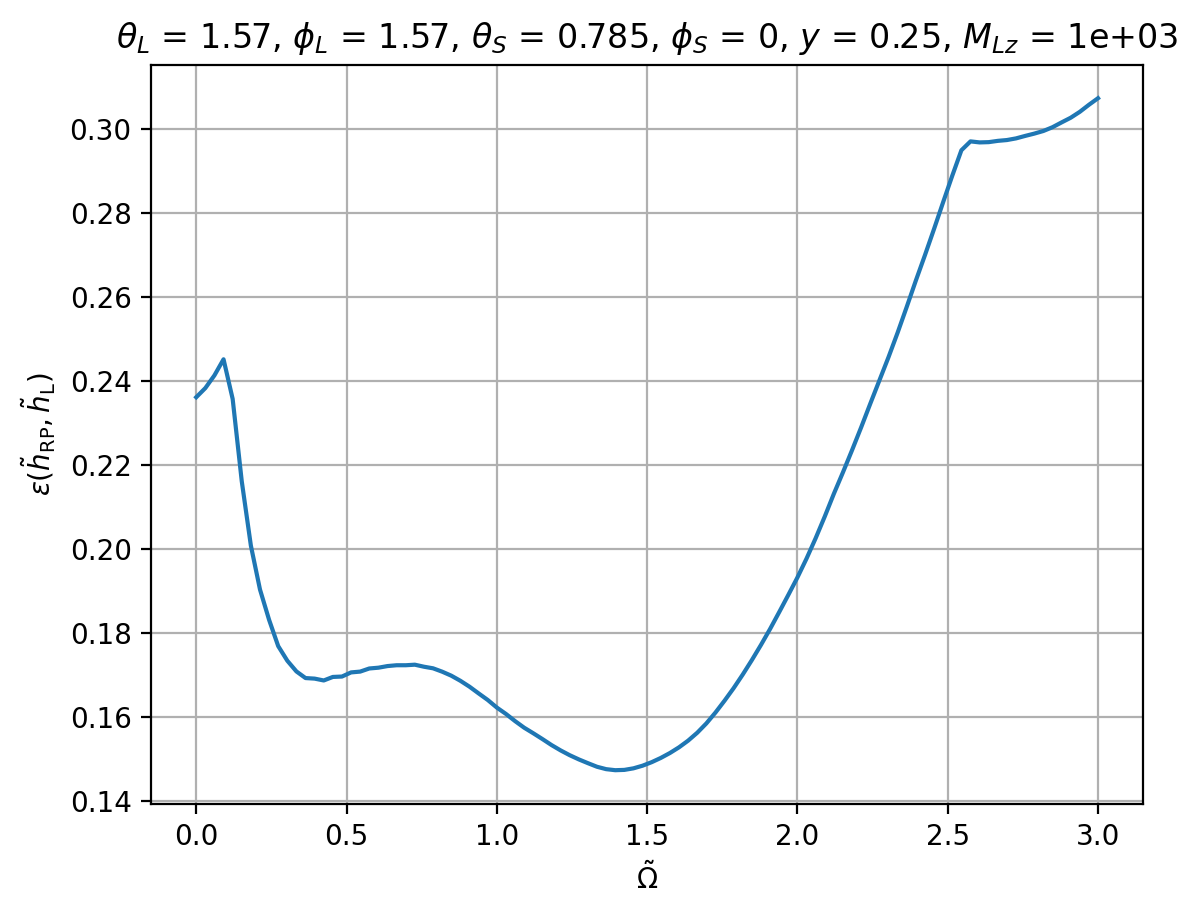

In [26]:
lens_params, RP_params, NP_params = set_to_params(
    lens_params_0, RP_params_0, NP_params_0
)

# set custom lensing & RP params
RP_params["theta_tilde"] = 8.0

# plot mismatch between RP & L as a function of omega_tilde
mismatch_slice_P_Omega("RP & L", lens_params, RP_params, NP_params, Lensing, Precessing)

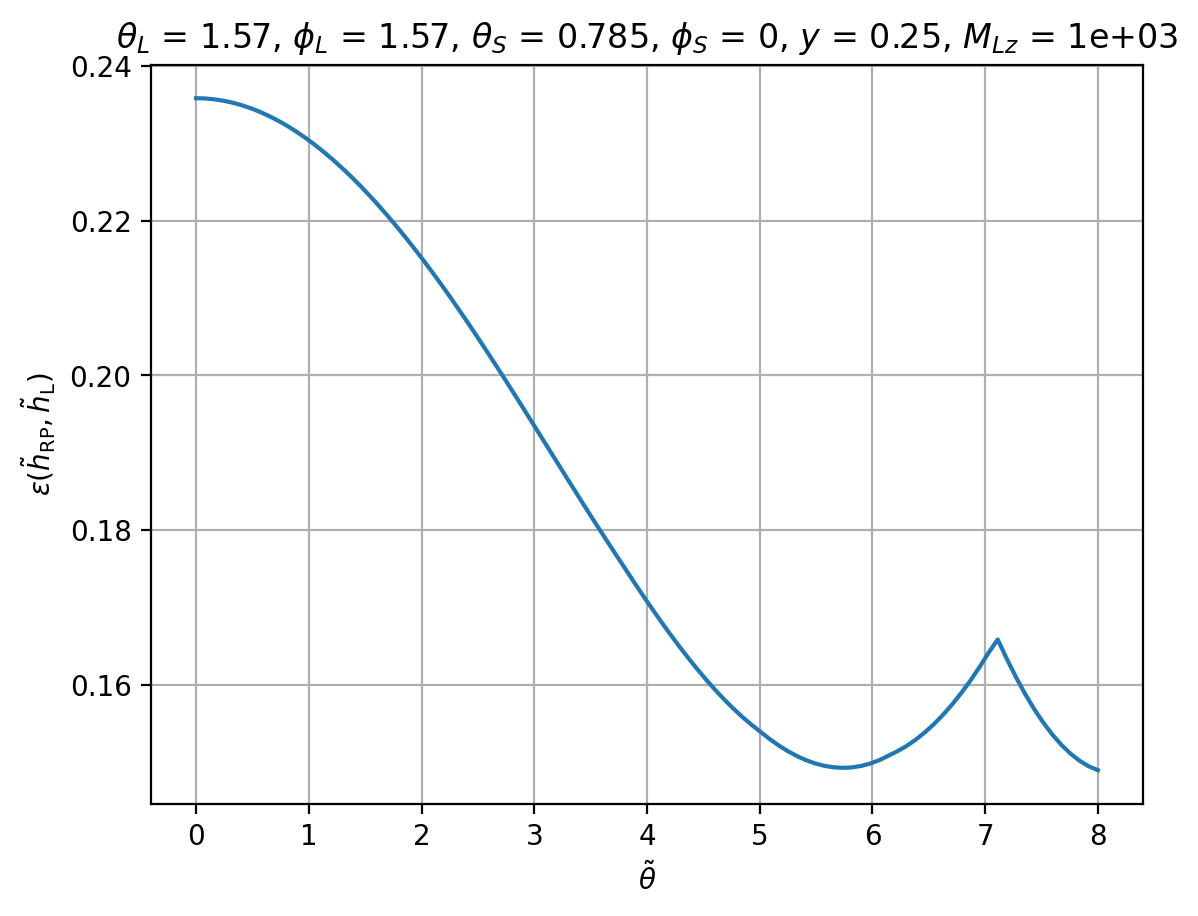

In [27]:
lens_params, RP_params, NP_params = set_to_params(
    lens_params_0, RP_params_0, NP_params_0
)

# set custom lensing & RP params
RP_params["omega_tilde"] = 1.5

# plot mismatch between RP & L as a function of theta_tilde
mismatch_slice_P_theta("RP & L", lens_params, RP_params, NP_params, Lensing, Precessing)

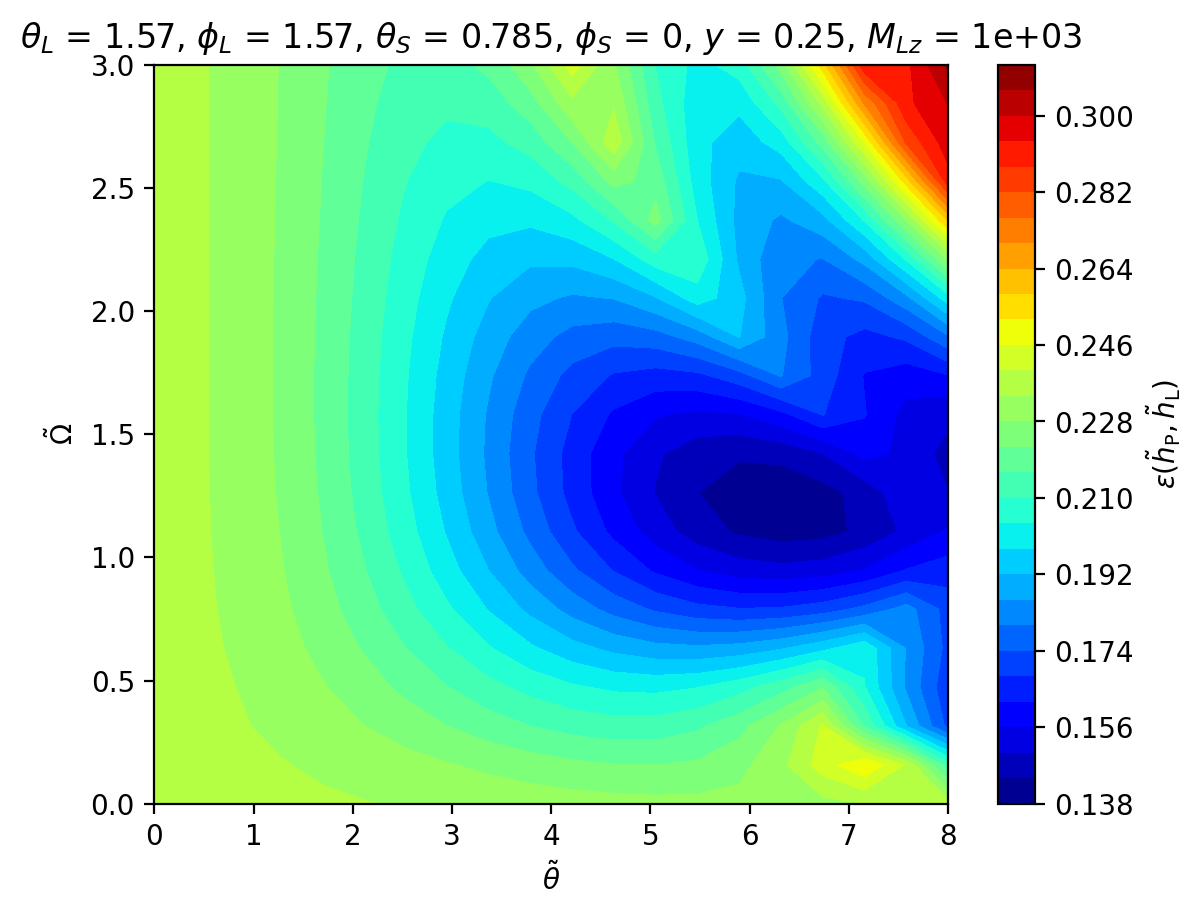

In [28]:
lens_params, RP_params, NP_params = set_to_params(
    lens_params_0, RP_params_0, NP_params_0
)

# plot mismatch contour between RP & L as a function of omega_tilde and theta_tilde
fig = mismatch_contour_P(
    "RP & L", lens_params, RP_params, NP_params, Lensing, Precessing
)

# test with Lensing (wave) & PrecessingTaman

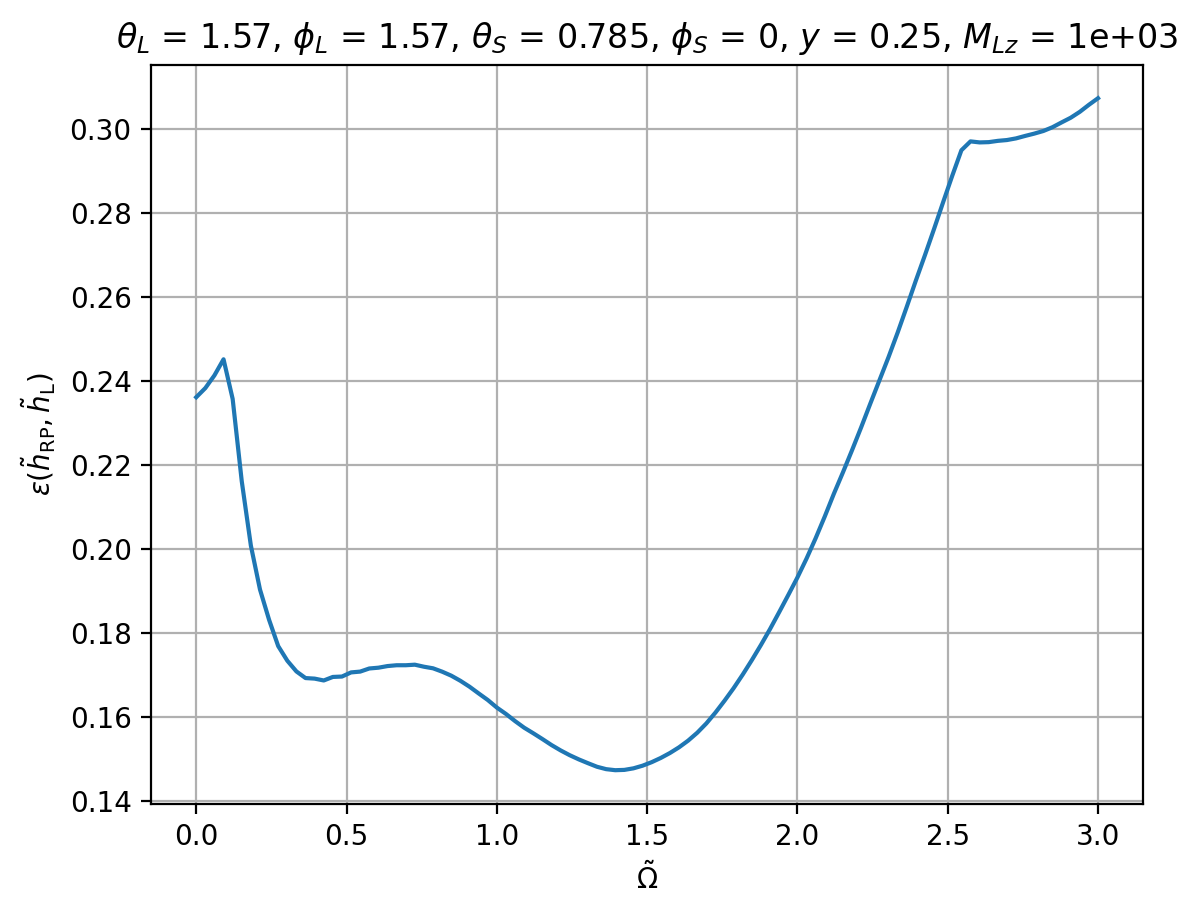

In [29]:
lens_params, RP_params, NP_params = set_to_params(
    lens_params_0, RP_params_0, NP_params_0
)

# set custom lensing & RP params
RP_params["theta_tilde"] = 8.0

# plot mismatch between RP & L as a function of omega_tilde
mismatch_slice_P_Omega(
    "RP & L", lens_params, RP_params, NP_params, Lensing, PrecessingTaman
)

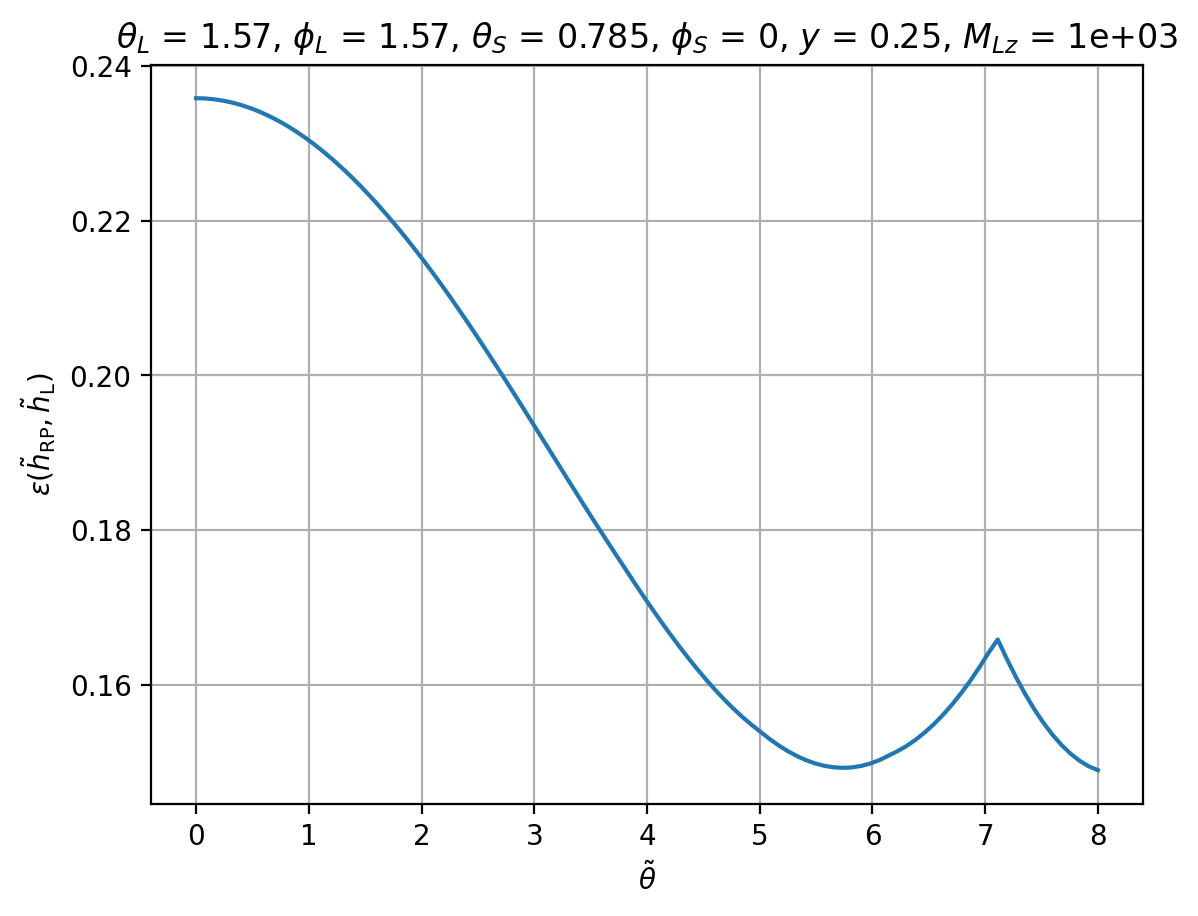

In [30]:
lens_params, RP_params, NP_params = set_to_params(
    lens_params_0, RP_params_0, NP_params_0
)

# set custom lensing & RP params
RP_params["omega_tilde"] = 1.5

# plot mismatch between RP & L as a function of theta_tilde
mismatch_slice_P_theta(
    "RP & L", lens_params, RP_params, NP_params, Lensing, PrecessingTaman
)

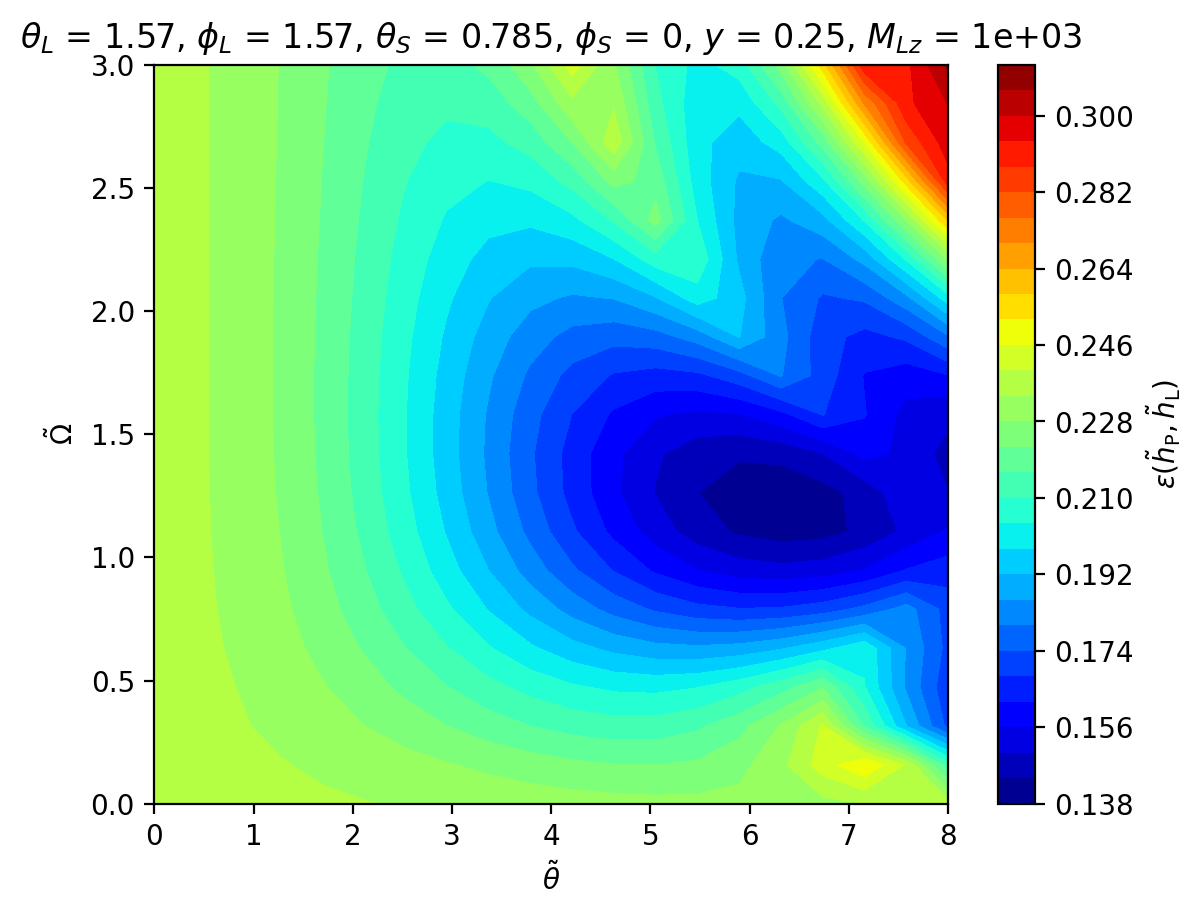

In [31]:
lens_params, RP_params, NP_params = set_to_params(
    lens_params_0, RP_params_0, NP_params_0
)

# plot mismatch contour between RP & L as a function of omega_tilde and theta_tilde
fig = mismatch_contour_P(
    "RP & L", lens_params, RP_params, NP_params, Lensing, PrecessingTaman
)

# test with LensingGeo & PrecessingTaman

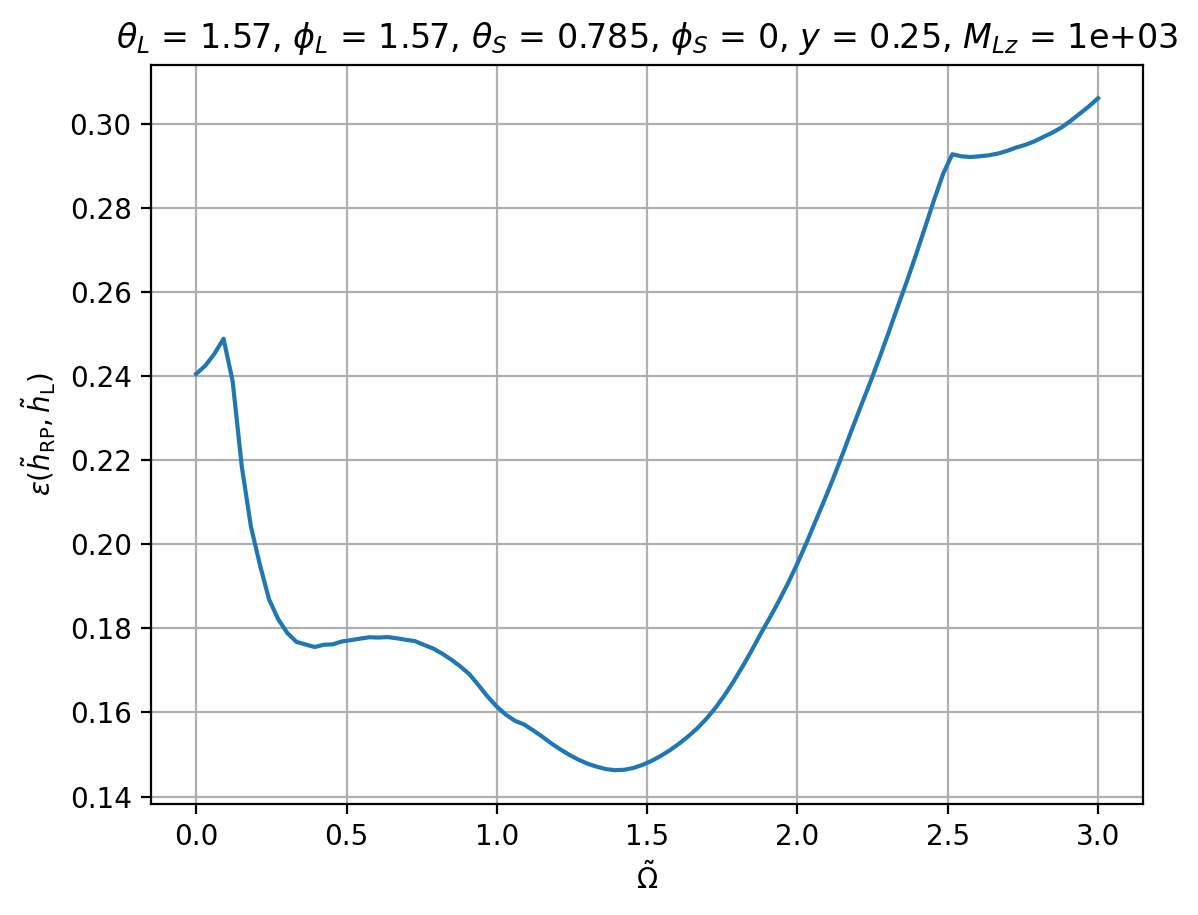

In [13]:
lens_params, RP_params, NP_params = set_to_params(
    lens_params_0, RP_params_0, NP_params_0
)

# set custom lensing & RP params
RP_params["theta_tilde"] = 8.0

# plot mismatch between RP & L as a function of omega_tilde
mismatch_slice_P_Omega(
    "RP & L", lens_params, RP_params, NP_params, LensingGeo, PrecessingTaman
)

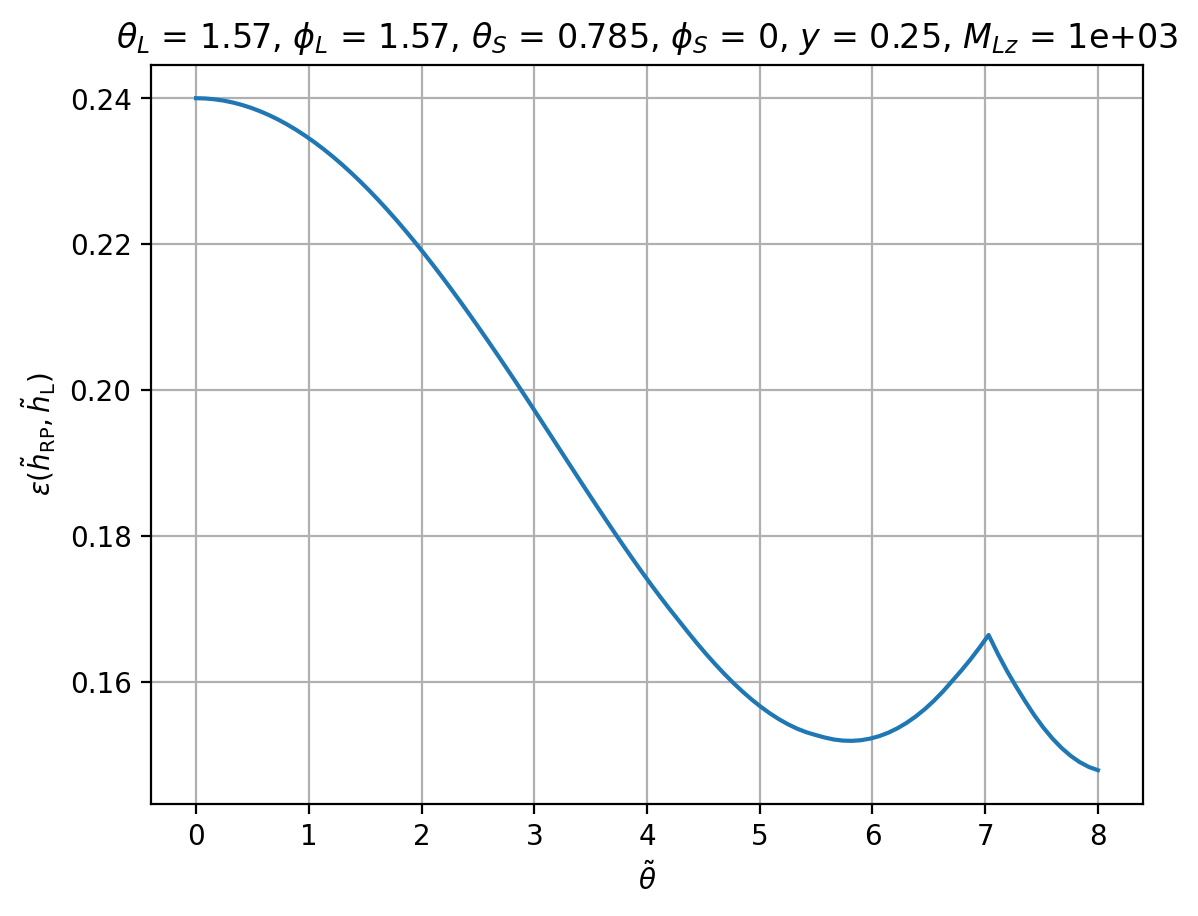

In [14]:
lens_params, RP_params, NP_params = set_to_params(
    lens_params_0, RP_params_0, NP_params_0
)

# set custom lensing & RP params
RP_params["omega_tilde"] = 1.5

# plot mismatch between RP & L as a function of theta_tilde
mismatch_slice_P_theta(
    "RP & L", lens_params, RP_params, NP_params, LensingGeo, PrecessingTaman
)

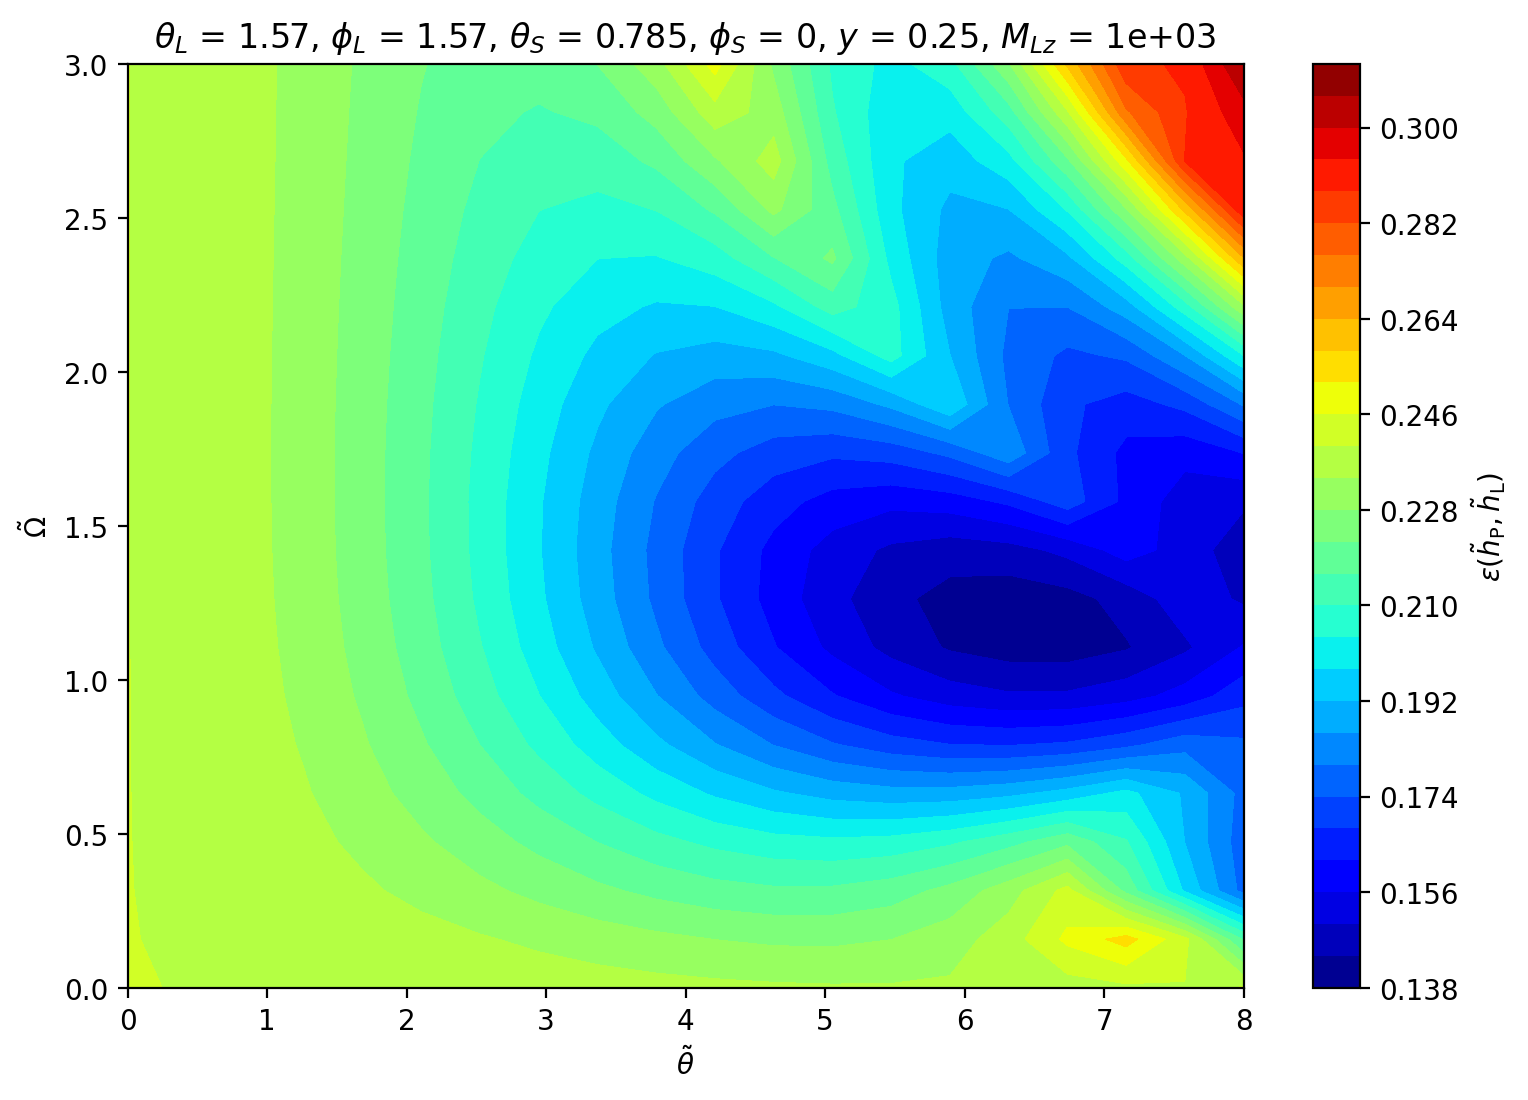

In [22]:
lens_params, RP_params, NP_params = set_to_params(
    lens_params_0, RP_params_0, NP_params_0
)

# plot mismatch contour between RP & L as a function of omega_tilde and theta_tilde
fig = mismatch_contour_P(
    "RP & L", lens_params, RP_params, NP_params, LensingGeo, PrecessingTaman
)

# test with LensingGeo & Precessing (Tien's version)

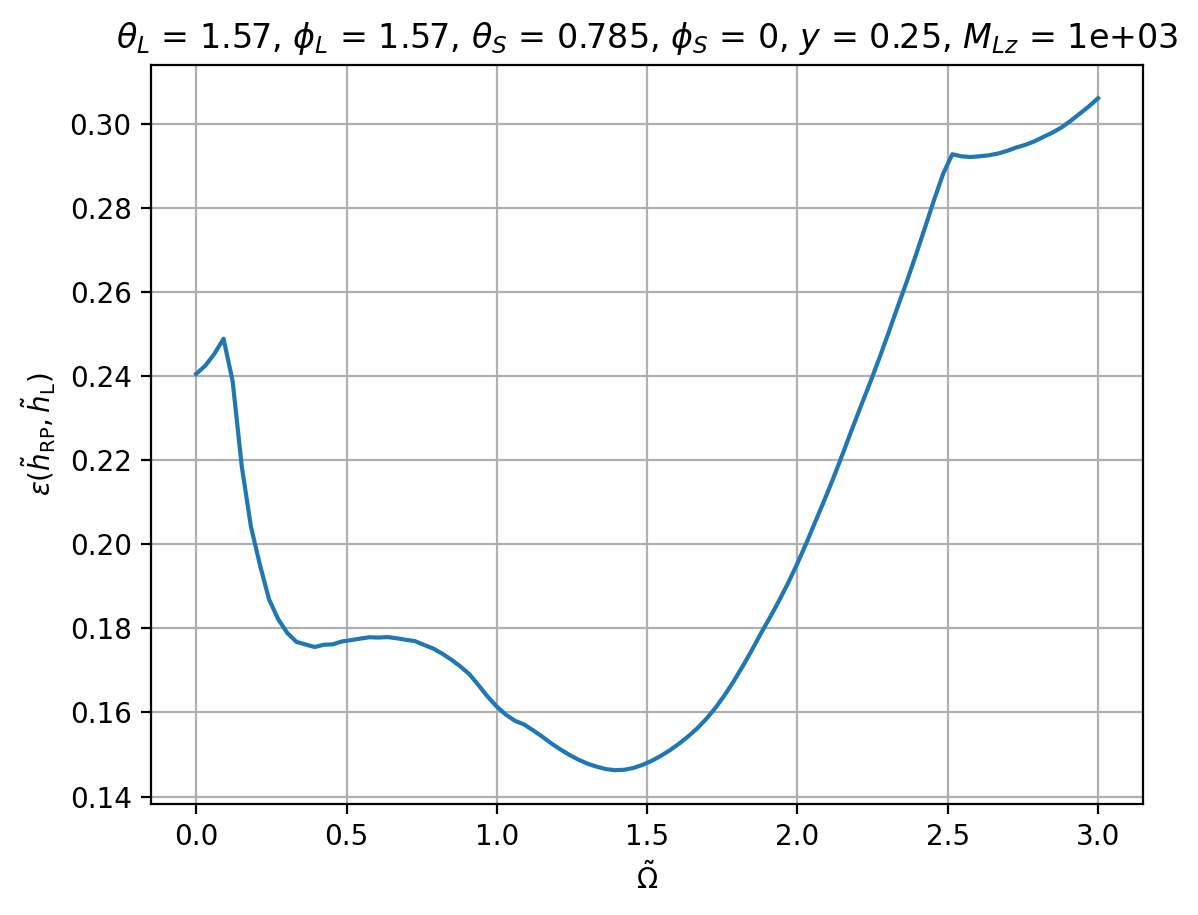

In [16]:
lens_params, RP_params, NP_params = set_to_params(
    lens_params_0, RP_params_0, NP_params_0
)

# set custom lensing & RP params
RP_params["theta_tilde"] = 8.0

# plot mismatch between RP & L as a function of omega_tilde
mismatch_slice_P_Omega(
    "RP & L", lens_params, RP_params, NP_params, LensingGeo, Precessing
)

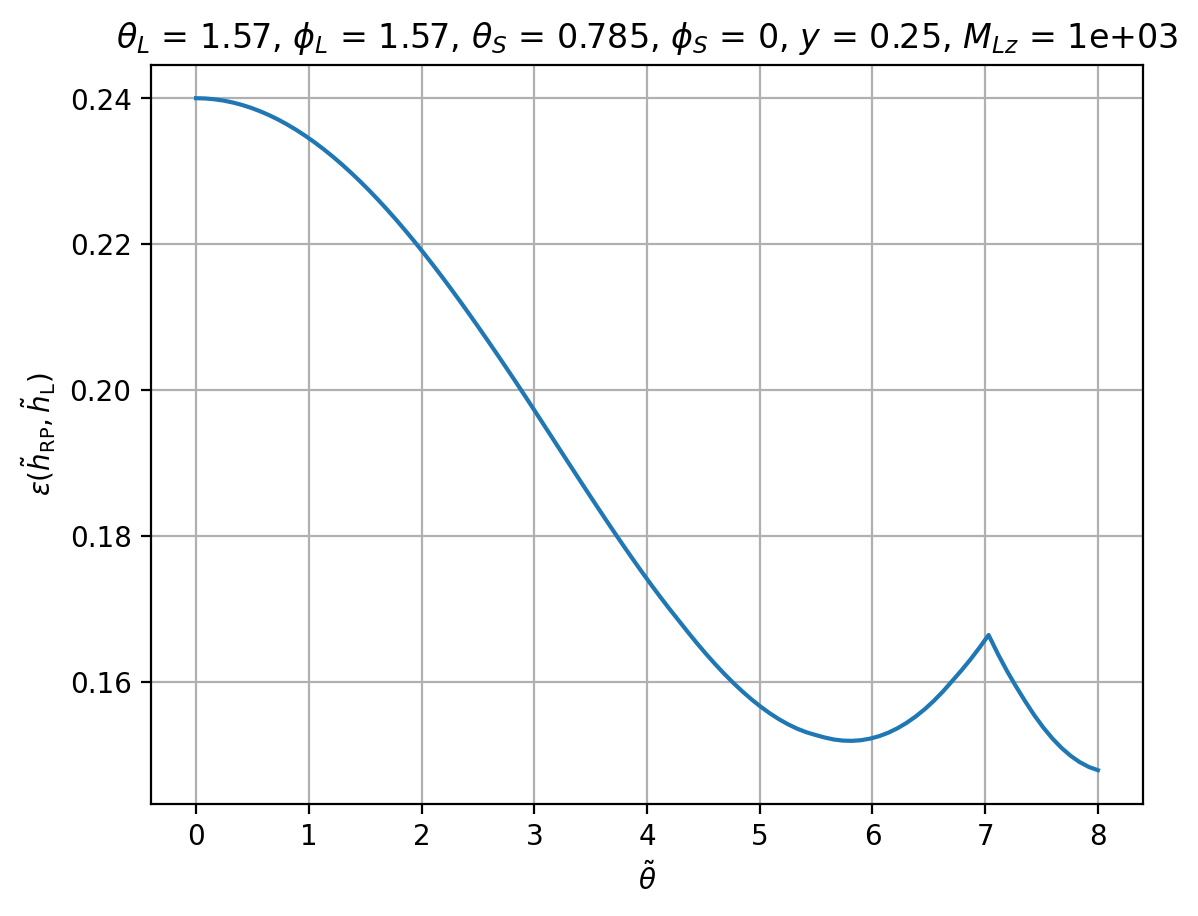

In [18]:
lens_params, RP_params, NP_params = set_to_params(
    lens_params_0, RP_params_0, NP_params_0
)

# set custom lensing & RP params
RP_params["omega_tilde"] = 1.5

# plot mismatch between RP & L as a function of theta_tilde
mismatch_slice_P_theta(
    "RP & L", lens_params, RP_params, NP_params, LensingGeo, Precessing
)

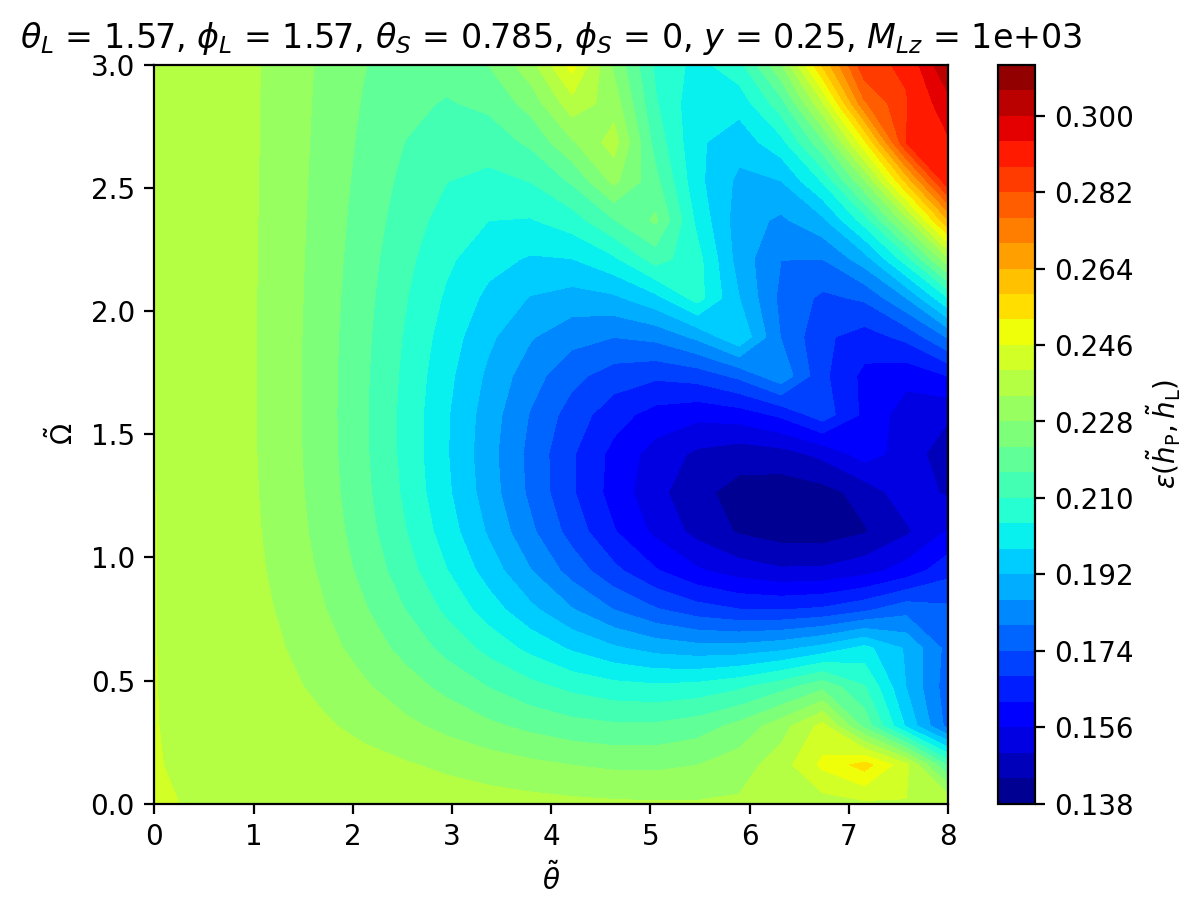

In [25]:
lens_params, RP_params, NP_params = set_to_params(
    lens_params_0, RP_params_0, NP_params_0
)

# plot mismatch contour between RP & L as a function of omega_tilde and theta_tilde
fig = mismatch_contour_P(
    "RP & L", lens_params, RP_params, NP_params, LensingGeo, Precessing
)

# test with Precessing (Tien's version)

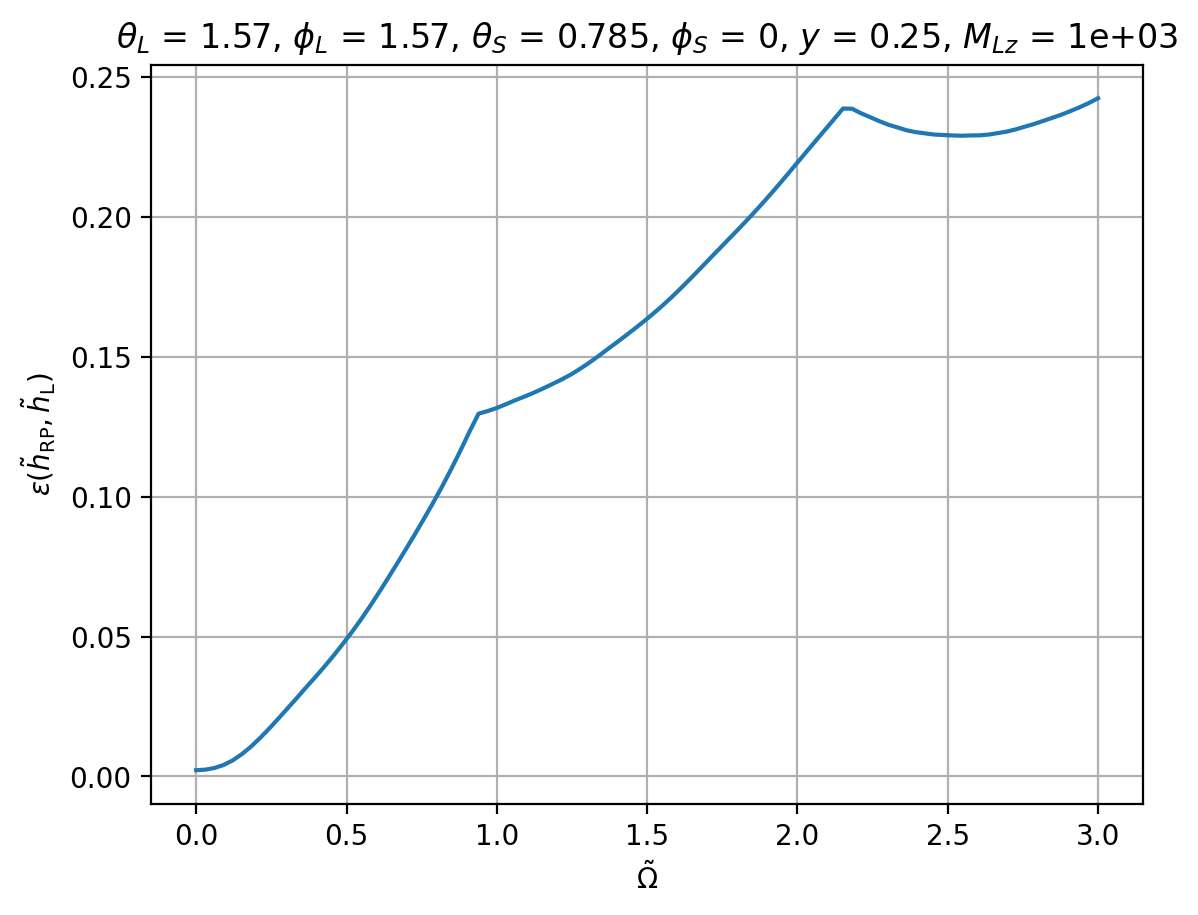

In [32]:
lens_params, RP_params, NP_params = set_to_params(
    lens_params_0, RP_params_0, NP_params_0
)

# set custom RP params
RP_params["theta_tilde"] = 8.0

# plot mismatch between RP & NP as a function of omega_tilde
mismatch_slice_P_Omega(
    "RP & NP", lens_params, RP_params, NP_params, LensingGeo, Precessing
)

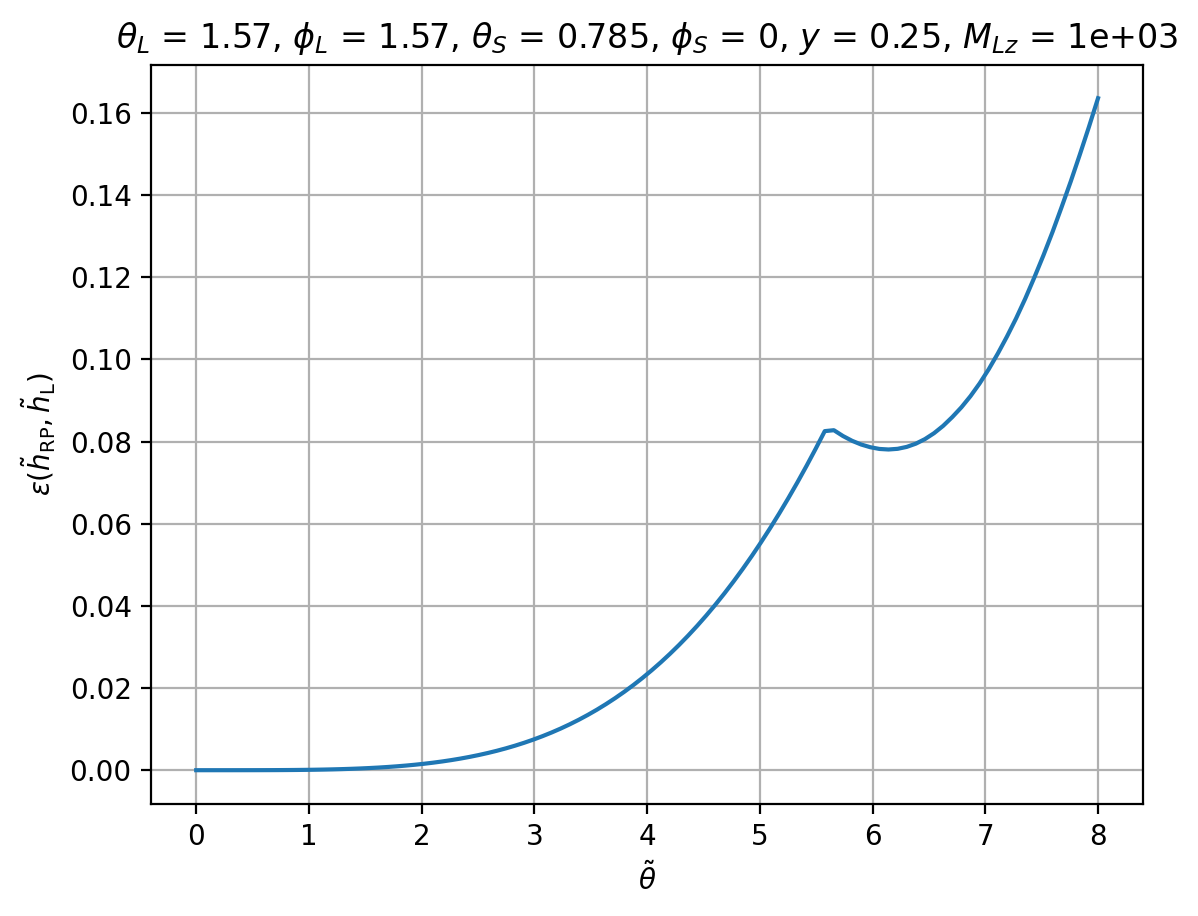

In [33]:
lens_params, RP_params, NP_params = set_to_params(
    lens_params_0, RP_params_0, NP_params_0
)

# set custom RP params
RP_params["omega_tilde"] = 1.5

# plot mismatch between RP & NP as a function of theta_tilde
mismatch_slice_P_theta(
    "RP & NP", lens_params, RP_params, NP_params, LensingGeo, Precessing
)

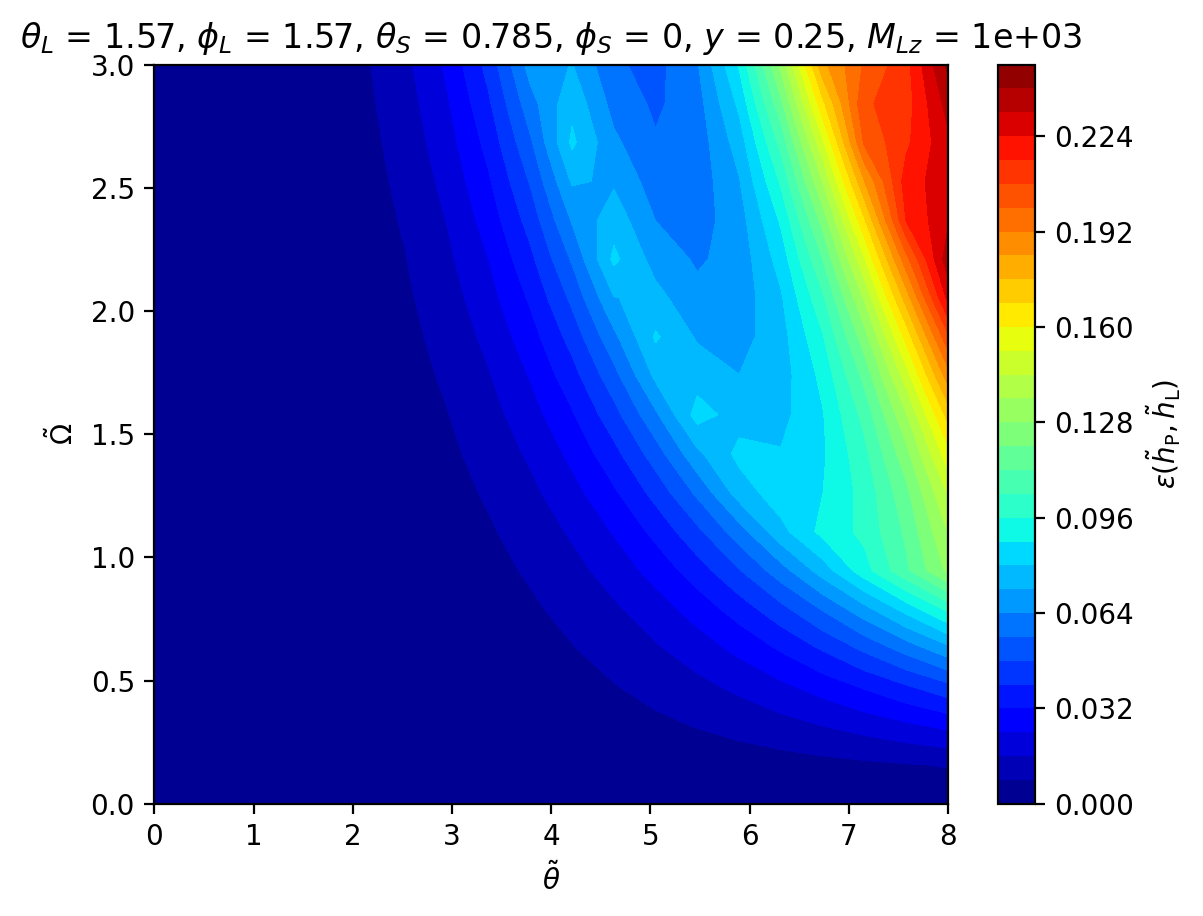

In [34]:
lens_params, RP_params, NP_params = set_to_params(
    lens_params_0, RP_params_0, NP_params_0
)

# plot mismatch contour between RP & NP as a function of omega_tilde and theta_tilde
fig = mismatch_contour_P(
    "RP & NP", lens_params, RP_params, NP_params, LensingGeo, Precessing
)